# Adult Income
### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import roc_curve, auc

## Load Data

In [2]:
df = pd.read_csv('./Data/adult.csv.zip')
df.head(3)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K


### Preprocessing of the dataset
1) Here looking at the dataset we can see that '?' exists denoting the missing values. 
We need to replace them with *NaN *using numpy's simple approach and replace them with the most occurring values or even the median of that column. 
We do not delete such row entries coz it will reduce our dataset by a factor of 0.25.

In [3]:
col_names = df.columns
for c in col_names:
	df[c] = df[c].replace("?", np.NaN)

df = df.apply(lambda x:x.fillna(x.value_counts().index[0]))

2) Now, we need to convert the categorical values to numeric for our Neural Network to train. 
Looking at the Marital-status col, there are nearly 6 different values which would mean the same as two values of being married or not married, therefore we convert them into only two values.

In [4]:
df.replace(['Divorced', 'Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent','Never-married','Separated','Widowed'],
             ['divorced','married','married','married','not married','not married','not married'], inplace = True)

3) Now we use labelEncoder to convert the categorical data into index values of an array of its inputs i.e. converting each value into a number. This is only done on attributes: 'race','marital-status', 'gender', 'income'; which do not contain more than 2 values.

NOTE : we do not want to fit our neural network into a model which contains a biased values for equivalent attribute values. To avoid this, we use Dummy variables method.

4) Here we implement get_dummies method of pandas lib to create new columns for our data where each attribute value's occurrence in any input instance is denoted by either 0 or 1.

In [5]:
labelEncoder = preprocessing.LabelEncoder()
category_col =['race','marital-status', 'gender', 'income'] 

for col in category_col:
    df[col] = labelEncoder.fit_transform(df[col])

category_col_1 =['workclass', 'education', 'occupation',
               'relationship','native-country'] 
df_2 = pd.get_dummies(df, columns=category_col_1, drop_first=True)

##unknown Attribute is removed and income class label is appended in the end
dataframe=df_2.drop('fnlwgt', 1)
dataframe =dataframe[[c for c in dataframe if c not in ['income']] + ['income']]
dataframe.head()

C:\Users\jdcal\AppData\Local\Temp/ipykernel_16144/4090538567.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  dataframe=df_2.drop('fnlwgt', 1)


,age,educational-num,marital-status,race,gender,capital-gain,capital-loss,hours-per-week,workclass_Local-gov,workclass_Never-worked,...,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,income
0,25,7,2,2,1,0,0,40,0,0,...,0,0,0,0,0,0,1,0,0,0
1,38,9,1,4,1,0,0,50,0,0,...,0,0,0,0,0,0,1,0,0,0
2,28,12,1,4,1,0,0,40,1,0,...,0,0,0,0,0,0,1,0,0,1
3,44,10,1,2,1,7688,0,40,0,0,...,0,0,0,0,0,0,1,0,0,1
4,18,10,2,4,0,0,0,30,0,0,...,0,0,0,0,0,0,1,0,0,0


## Training the Neural Network
1) Now we train and test the data on the model using cross validation method.

2) Also, we Standardize features by removing the mean and scaling to unit variance.
Standardization of a dataset is a common requirement for many machine learning estimators.
They might behave badly if the individual feature do not more or less look like standard normally distributed data (e.g. Gaussian with 0 mean and unit variance).

In [6]:
X = dataframe.iloc[:, 0:88].values
y = dataframe.iloc[:, 88].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

2) I have used a simple model of a neural network where there is one input layer, one output layer and one hidden layer. 
The inputs are fed into input layer of only 6 neurons or nodes whose output is fed to hidden layer of 6 neurons and which eventually are fed to one node output layer. 
The first two use Rectified Linear Unit activation function but the Output layer used sigmoid activation function to ensure our network output is between 0 and 1. 
We run the training model for 100 epochs.

In [7]:
classifier = Sequential()

classifier.add(Dense(6, activation = 'relu', input_dim = 88))
classifier.add(Dense(6, activation = 'relu'))
classifier.add(Dense(1, activation = 'sigmoid'))
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
                   
classifier.fit(X_train, y_train, batch_size = 10)

y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)

3908/3908 [==============================] - 4s 984us/step - loss: 0.3701 - accuracy: 0.8245

## Results
Now we plot the results and visualize the performance of the Neural Network by using classification report, confusion matrix and ROC curve.


Accuracy ========== >>>  85.41%


Classification Report

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      7376
           1       0.73      0.60      0.66      2393

    accuracy                           0.85      9769
   macro avg       0.80      0.76      0.78      9769
weighted avg       0.84      0.85      0.84      9769



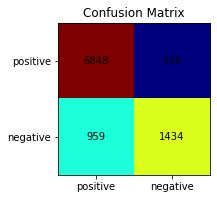

In [8]:
print ("\nAccuracy ========== >>>  85.41%\n")

#classification report
print ("\nClassification Report\n")
print (classification_report(y_test, y_pred))

conf_arr =confusion_matrix(y_test, y_pred)
norm_conf = []
for i in conf_arr:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        tmp_arr.append(float(j)/float(a))
    norm_conf.append(tmp_arr)

fig = plt.figure()
plt.clf()
ax = fig.add_subplot(1,2,1)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_conf), cmap=plt.cm.jet, 
                interpolation='nearest')

width, height = conf_arr.shape

for x in range(width):
    for y in range(height):
        ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')
## confusion matrix
plt.title("Confusion Matrix")
plt.xticks(range(width), ['positive','negative'])
plt.yticks(range(height), ['positive','negative'])
plt.show()

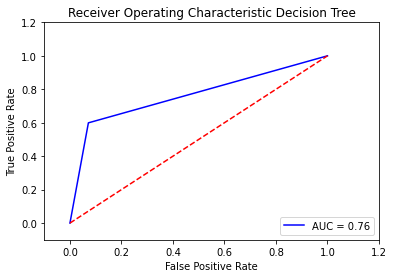

In [9]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic Decision Tree')
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [10]:
##gini coefficient
Gini_coefficient=2*roc_auc - 1
print("Gini_coefficient from the ROC curve is \n",Gini_coefficient)

Gini_coefficient from the ROC curve is 
 0.527664292001345
